https://disk.yandex.ru/d/dpksnSnV2gXUwQ

In [1]:
#%pip install --upgrade pandas

In [2]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import gc
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

import pickle

from lightgbm import LGBMClassifier

In [3]:

def load_pkl_file(file_path):
    """
    Загружает данные из .pkl файла с обработкой ошибок
    
    Параметры:
        file_path (str): Путь к .pkl файлу
    
    Возвращает:
        DataFrame: Загруженные данные или None при ошибке
    """
    try:
        if not Path(file_path).exists():
            raise FileNotFoundError(f"Файл {file_path} не найден")

        with open(file_path, 'rb') as f:
            data = pickle.load(f, encoding='latin1')  # или 'bytes'

        if not isinstance(data, pd.DataFrame):
            raise TypeError("Файл не содержит DataFrame")

        print(f"Успешно загружен файл {file_path}")
        return data

    except Exception as e:
        print(f"Ошибка при загрузке {file_path}: {str(e)}")
        return None

# Пример использования:
#ga_sessions = load_pkl_file('ga_sessions.pkl')
#ga_hits = load_pkl_file('ga_hits.pkl')
ga_sessions = pd.read_csv('ga_sessions.csv', sep=',')
ga_hits = pd.read_csv('ga_hits.csv', sep=',')

C:\Users\Aria\AppData\Local\Temp\ipykernel_16064\1956016661.py:31: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ga_sessions = pd.read_csv('ga_sessions.csv', sep=',')


In [4]:
def inform(data):
    # Вывод информации о датасете
    print("Информация о датасете:")
    data.info()
    
    # Разделительная строка
    print("\n" + "="*50 + "\n")
    
    # Вывод первых нескольких строк датасета
    print("Первые несколько строк датасета:")
    display(data.head())
    
    # Разделительная строка
    print("\n" + "="*50 + "\n")
    
    #describe
    print('Описательная статистика:')
    display(data.describe())

    # Разделительная строка
    print("\n" + "="*50 + "\n")
    
    print('Количество пропусков')
    for col in data.columns:
        print(f'{col}: {data[col].isna().sum()}')
        
    # Разделительная строка
    print("\n" + "="*50 + "\n")
    
    display(f'Количествово дубликатов:{data.duplicated().sum()}')   

    # Разделительная строка
    print("\n" + "="*50 + "\n")
    
    print('Количество уникальных значений')
    for col in data.columns:
        print(f'{col}: {data[col].nunique()}') 

In [5]:
def encode_column_with_nulls(df, column_name):
    """
    Кодирует значения в указанном столбце числовыми метками (начиная с 1),
    заменяя пропуски (NaN) на 0.

    Параметры:
    -----------
    df : pandas.DataFrame
        Исходный датафрейм
    column_name : str
        Название столбца для кодирования

    Возвращает:
    -----------
    pandas.DataFrame
        Датафрейм с добавленным столбцом {column_name}_encoded
    """
    # Создаем копию датафрейма, чтобы избежать предупреждений
    df = df.copy()
    
    # Кодируем значения (na_sentinel=-1 для пропусков)
    encoded, uniques = pd.factorize(df[column_name])
    
    # Создаем новый столбец (сдвигаем на +1, чтобы начать с 1)
    df[f'{column_name}_encoded'] = encoded + 1
    
    # Заменяем -1+1=0 на 0 для пропусков
    df[f'{column_name}_encoded'] = df[f'{column_name}_encoded'].replace(0, 0)
    
    # Приводим к целочисленному типу
    df[f'{column_name}_encoded'] = df[f'{column_name}_encoded'].astype('int64')
    
    # Выводим информацию о кодировании
    print(f"Кодирование столбца '{column_name}':")
    print(f"Уникальных значений: {len(uniques)}")
    print(f"Максимальный код: {df[f'{column_name}_encoded'].max()}")
    print("Распределение значений:")
    print(df[f'{column_name}_encoded'].value_counts().head())
    
    return df

In [6]:
inform(ga_sessions)

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 18 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_source                object
 6   utm_medium                object
 7   utm_campaign              object
 8   utm_adcontent             object
 9   utm_keyword               object
 10  device_category           object
 11  device_os                 object
 12  device_brand              object
 13  device_model              object
 14  device_screen_resolution  object
 15  device_browser            object
 16  geo_country               object
 17  geo_city                  object
dtypes: int64(1), object(17)
memory usage: 255.4+ MB


Первые несколько строк датасета:


,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow




Описательная статистика:


,visit_number
count,1.860042e+06
mean,2.712804e+00
std,1.182907e+01
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,2.000000e+00
max,5.640000e+02




Количество пропусков
session_id: 0
client_id: 0
visit_date: 0
visit_time: 0
visit_number: 0
utm_source: 97
utm_medium: 0
utm_campaign: 219603
utm_adcontent: 335615
utm_keyword: 1082061
device_category: 0
device_os: 1070138
device_brand: 367178
device_model: 1843704
device_screen_resolution: 0
device_browser: 0
geo_country: 0
geo_city: 0




'Количествово дубликатов:0'



Количество уникальных значений
session_id: 1860042
client_id: 1391717
visit_date: 226
visit_time: 85318
visit_number: 537
utm_source: 293
utm_medium: 56
utm_campaign: 412
utm_adcontent: 286
utm_keyword: 1219
device_category: 3
device_os: 13
device_brand: 205
device_model: 104
device_screen_resolution: 5039
device_browser: 57
geo_country: 166
geo_city: 2548


In [7]:
# Выбираем столбцы с менее чем 100 уникальными значениями
cols_to_show = [col for col in ga_sessions.columns 
                if ga_sessions[col].nunique() < 100 and 
                pd.api.types.is_categorical_dtype(ga_sessions[col]) or 
                pd.api.types.is_object_dtype(ga_sessions[col])]

# Выводим уникальные значения для каждого отобранного столбца
for col in cols_to_show:
    nunique = ga_sessions[col].nunique()
    print(f"\nСтолбец: {col} (уникальных значений: {nunique})")
    print("----------------------------------------")
    
    # Для столбцов с небольшим количеством уникальных значений показываем все
    if nunique <= 20:
        print(ga_sessions[col].unique())
    else:
        # Для столбцов с 20-100 значениями показываем первые 20
        print(f"Первые 5 из {nunique} значений:")
        print(ga_sessions[col].unique()[:5])
    
    # Дополнительная информация о распределении
    print(f"\nТоп-5 наиболее частых значений:")
    print(ga_sessions[col].value_counts().head())
    
    print(f"\nТоп-5 наиболее редких значений:")
    print(ga_sessions[col].value_counts().tail())

C:\Users\Aria\AppData\Local\Temp\ipykernel_16064\807358194.py:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  pd.api.types.is_categorical_dtype(ga_sessions[col]) or



Столбец: session_id (уникальных значений: 1860042)
----------------------------------------
Первые 5 из 1860042 значений:
['9055434745589932991.1637753792.1637753792'
 '905544597018549464.1636867290.1636867290'
 '9055446045651783499.1640648526.1640648526'
 '9055447046360770272.1622255328.1622255328'
 '9055447046360770272.1622255345.1622255345']

Топ-5 наиболее частых значений:
session_id
9055434745589932991.1637753792.1637753792    1
6294640354816492625.1638728787.1638728809    1
6294832296889291185.1623245519.1623245519    1
6294832296889291185.1623161065.1623161065    1
6294832296889291185.1623156608.1623156608    1
Name: count, dtype: int64

Топ-5 наиболее редких значений:
session_id
3525580570051063315.1625927189.1625927189    1
3525573324456022940.1640876964.1640876964    1
3525573324456022940.1640837067.1640837067    1
3525573324456022940.1640715164.1640715164    1
9055430416266113553.1640968742.1640968742    1
Name: count, dtype: int64

Столбец: client_id (уникальных значений: 

visit_date

In [8]:
ga_sessions['visit_date'] = pd.to_datetime(ga_sessions['visit_date'])
ga_sessions['year'] = ga_sessions['visit_date'].dt.year
ga_sessions['year'] = ga_sessions['year'].astype('int16')

ga_sessions['month'] = ga_sessions['visit_date'].dt.month
ga_sessions['month'] = ga_sessions['month'].astype('int16')

ga_sessions['day'] = ga_sessions['visit_date'].dt.day
ga_sessions['day'] = ga_sessions['day'].astype('int16')

In [9]:
ga_sessions['day_of_week_num'] = ga_sessions['visit_date'].dt.dayofweek
ga_sessions['day_of_week_num']

0          2
1          6
2          1
3          5
4          5
          ..
1860037    2
1860038    2
1860039    0
1860040    0
1860041    4
Name: day_of_week_num, Length: 1860042, dtype: int32

visit_number

In [10]:
#ga_sessions['visit_number'].unique()

utm_medium device_category	device_os	device_brand	device_model	device_screen_resolution	device_browser

In [13]:
def fill_missing_by_groups(df):
    df_filled = df.copy()
    
    # 1. Предварительная обработка специальных значений
    df_filled['utm_medium'] = df_filled['utm_medium'].replace(['(none)', 'none'], pd.NA)
    
    # 2. Заполнение device атрибутов
    # Для desktop устройств
    #df_filled.loc[df_filled['device_category'] == 'desktop', 'device_brand'] = 'desktop'
    
    # Для mobile/tablet устройств
    #mobile_tablet_mask = df_filled['device_category'].isin(['mobile', 'tablet'])
    #if mobile_tablet_mask.any():
    #    # Создаем маппинг brand -> model
    #    brand_model = df_filled[mobile_tablet_mask].dropna(subset=['device_brand', 'device_model'])\
    #        .groupby('device_brand')['device_model'].first()
        
        # Заполняем device_model на основе device_brand
    #    df_filled.loc[mobile_tablet_mask, 'device_model'] = df_filled.loc[mobile_tablet_mask, 'device_model']\
    #        .fillna(df_filled.loc[mobile_tablet_mask, 'device_brand'].map(brand_model))
    
    # 3. Заполнение UTM атрибутов через группировку только по utm_medium
    
    # Связка 1: utm_medium + device_category -> utm_source
    if 'utm_source' in df_filled.columns:
        source_by_medium_device = df_filled.dropna(subset=['utm_source'])\
            .groupby(['utm_medium', 'device_category'])['utm_source'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
        
        df_filled['utm_source'] = df_filled.apply(
            lambda row: source_by_medium_device.get((row['utm_medium'], row['device_category']), row['utm_source'])
            if pd.isna(row['utm_source']) 
            else row['utm_source'],
            axis=1
        )
    
    # Связка 2: utm_medium + device_os -> utm_campaign
    if 'utm_campaign' in df_filled.columns:
        campaign_map = df_filled.dropna(subset=['utm_campaign'])\
            .groupby(['utm_medium', 'device_os'])['utm_campaign'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
        
        df_filled['utm_campaign'] = df_filled.apply(
            lambda row: campaign_map.get((row['utm_medium'], row['device_os']), row['utm_campaign'])
            if pd.isna(row['utm_campaign']) 
            else row['utm_campaign'],
            axis=1
        )
    
    # 4. Заполнение device атрибутов через группировку
    
    # Заполнение device_browser на основе device_os + device_screen_resolution
    #if 'device_browser' in df_filled.columns:
    #    browser_map = df_filled.dropna(subset=['device_browser'])\
    #        .groupby(['device_os', 'device_screen_resolution'])['device_browser'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
    #    
    #   df_filled['device_browser'] = df_filled.apply(
    #        lambda row: browser_map.get((row['device_os'], row['device_screen_resolution']), row['device_browser'])
    #        if pd.isna(row['device_browser']) 
    #        else row['device_browser'],
    #        axis=1
    #    )
    
    # 5. Заполнение оставшихся пропусков наиболее частыми значениями в группах
    group_columns = ['utm_medium', 'device_category', 'device_os']
    for col in df_filled.columns:
        if df_filled[col].isna().any():
            # Заполняем оставшиеся пропуски модой по указанным группам
            mode_by_group = df_filled.dropna(subset=[col])\
                .groupby(group_columns)[col].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
            
            df_filled[col] = df_filled.apply(
                lambda row: mode_by_group.get(tuple(row[group_columns]), row[col])
                if pd.isna(row[col]) 
                else row[col],
                axis=1
            )
    
    # 6. Финальное заполнение модой для оставшихся пропусков
    for col in df_filled.columns:
        if df_filled[col].isna().any():
            mode_val = df_filled[col].mode()
            if not mode_val.empty:
                df_filled[col] = df_filled[col].fillna(mode_val[0])
    
    return df_filled

# Применяем функцию
ga_sessions_filled = fill_missing_by_groups(ga_sessions)

utm_source

In [14]:
ga_sessions_filled['utm_source'].nunique()

293

In [15]:
ga_sessions_filled = encode_column_with_nulls(ga_sessions_filled, 'utm_source')

Кодирование столбца 'utm_source':
Уникальных значений: 293
Максимальный код: 293
Распределение значений:
utm_source_encoded
1    578343
5    300575
3    266354
2    186199
8    116320
Name: count, dtype: int64


utm_medium

In [ ]:
#ga_sessions['utm_medium'].unique()

utm_campaign

In [ ]:
ga_sessions_filled['utm_campaign'].nunique()

412

In [16]:
ga_sessions_filled = encode_column_with_nulls(ga_sessions_filled, 'utm_campaign')

Кодирование столбца 'utm_campaign':
Уникальных значений: 412
Максимальный код: 412
Распределение значений:
utm_campaign_encoded
3    603233
1    324044
2    274451
4    134042
7     77247
Name: count, dtype: int64


utm_adcontent

In [ ]:
ga_sessions['utm_adcontent'].nunique()

286

In [ ]:
#ga_sessions_filled = encode_column_with_nulls(ga_sessions_filled, 'utm_adcontent')

utm_keyword

In [ ]:
ga_sessions_filled['utm_keyword'].nunique()

1219

In [ ]:
#ga_sessions_filled = encode_column_with_nulls(ga_sessions_filled, 'utm_keyword')

device_model

In [17]:
ga_sessions_filled = encode_column_with_nulls(ga_sessions_filled, 'device_model')

Кодирование столбца 'device_model':
Уникальных значений: 104
Максимальный код: 104
Распределение значений:
device_model_encoded
1     1852534
7         716
12        653
13        651
6         461
Name: count, dtype: int64


device_category

In [ ]:
ga_sessions_filled['device_category'].unique()

array(['mobile', 'tablet', 'desktop'], dtype=object)

device_os

In [ ]:
ga_sessions_filled['device_os'].unique()

array(['Android', 'iOS', 'Windows', 'Linux', 'Macintosh', '(not set)',
       'Chrome OS', 'BlackBerry', 'Tizen', 'Firefox OS', 'Samsung',
       'Windows Phone', 'Nokia'], dtype=object)

geo_country

In [18]:
ga_sessions_filled['geo_country'] = ga_sessions_filled['geo_country'].apply(lambda x: 1 if x == 'Russia' else 0)

geo_city

In [19]:
# Рассчитываем порог (1% от общего количества событий)
threshold = len(ga_sessions_filled) * 0.01

# Создаем словарь для замены значений
value_counts = ga_sessions_filled['geo_city'].value_counts()
replace_dict = {category: 'OTHER' 
                for category in value_counts[value_counts < threshold].index}

# Создаем новый столбец с объединенными категориями
ga_sessions_filled['geo_city_grouped'] = ga_sessions_filled['geo_city'].replace(replace_dict)

# Строим интерактивную диаграмму
city_counts = ga_sessions_filled['geo_city_grouped'].value_counts().reset_index()
city_counts.columns = ['city', 'count']  # Переименовываем столбцы для ясности

# Строим интерактивную диаграмму
fig = px.bar(city_counts,
             x='city',  # Используем новое имя столбца
             y='count',
             labels={'city': 'Город', 
                    'count': 'Количество событий'},
             title=f'Распределение городов (города < {threshold:,.0f} событий объединены в OTHER)',
             text_auto=True,
             color='city',
             color_discrete_sequence=px.colors.qualitative.Plotly)

# Настраиваем отображение
fig.update_layout(
    xaxis_title="Город",
    yaxis_title="Количество событий",
    xaxis={'categoryorder':'total descending'},
    showlegend=False,
    hovermode="x"
)

# Добавляем подпись с количеством объединенных категорий
other_count = len(value_counts[value_counts < threshold])
fig.add_annotation(
    x='OTHER',
    y=city_counts.loc[city_counts['city'] == 'OTHER', 'count'].values[0],
    text=f"{other_count} городов объединены",
    showarrow=True,
    arrowhead=1,
    ax=0,
    ay=-40
)

fig.show()

C:\Users\Aria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\plotly\express\_core.py:2065: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


utm_source

In [20]:
ga_sessions_filled[ga_sessions_filled['utm_source'].isna()].head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,...,geo_country,geo_city,year,month,day,day_of_week_num,utm_source_encoded,utm_campaign_encoded,device_model_encoded,geo_city_grouped


In [21]:
inform(ga_hits)

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      object 
 1   hit_date        object 
 2   hit_time        float64
 3   hit_number      int64  
 4   hit_type        object 
 5   hit_referer     object 
 6   hit_page_path   object 
 7   event_category  object 
 8   event_action    object 
 9   event_label     object 
 10  event_value     float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.3+ GB


Первые несколько строк датасета:


,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN




Описательная статистика:


,hit_time,hit_number,event_value
count,6.566148e+06,1.572647e+07,0.0
mean,2.091050e+05,2.356715e+01,NaN
std,4.032110e+05,2.887713e+01,NaN
min,0.000000e+00,1.000000e+00,NaN
25%,2.412000e+04,7.000000e+00,NaN
50%,8.994100e+04,1.500000e+01,NaN
75%,2.195352e+05,2.900000e+01,NaN
max,1.315688e+07,5.000000e+02,NaN




Количество пропусков
session_id: 0
hit_date: 0
hit_time: 9160322
hit_number: 0
hit_type: 0
hit_referer: 6274804
hit_page_path: 0
event_category: 0
event_action: 0
event_label: 3760184
event_value: 15726470




'Количествово дубликатов:0'



Количество уникальных значений
session_id: 1734610
hit_date: 226
hit_time: 925887
hit_number: 500
hit_type: 1
hit_referer: 37873
hit_page_path: 342715
event_category: 52
event_action: 230
event_label: 39825
event_value: 0


event_value

In [22]:
def fill_hits_and_events(df):
    """
    Заполняет пропуски в столбцах hit и event на основе группировки данных
    """
    df_filled = df.copy()
    
    # 2. Заполнение hit_referer на основе hit_page_path
    if 'hit_referer' in df_filled.columns and df_filled['hit_referer'].isna().any():
        referer_by_page = df_filled.dropna(subset=['hit_referer', 'hit_page_path'])\
            .groupby('hit_page_path')['hit_referer'].first()
        
        df_filled['hit_referer'] = df_filled.apply(
            lambda row: referer_by_page.get(row['hit_page_path'], row['hit_referer'])
            if pd.isna(row['hit_referer'])
            else row['hit_referer'],
            axis=1
        )
    
    # 3. Заполнение event_label на основе event_action
    if 'event_label' in df_filled.columns and df_filled['event_label'].isna().any():
        label_by_action = df_filled.dropna(subset=['event_action', 'event_label'])\
            .groupby('event_action')['event_label'].first()
        
        df_filled['event_label'] = df_filled.apply(
            lambda row: label_by_action.get(row['event_action'], row['event_label'])
            if pd.isna(row['event_label'])
            else row['event_label'],
            axis=1
        )

    # 5. Заполнение оставшихся пропусков
    # Для hit_referer - если не нашли по page_path, заполняем 'direct'
    if 'hit_referer' in df_filled.columns:
        df_filled['hit_referer'] = df_filled['hit_referer'].fillna('direct')
    
    # Для event_label - если не нашли по action, заполняем 'none'
    if 'event_label' in df_filled.columns:
        df_filled['event_label'] = df_filled['event_label'].fillna('none')
    
    return df_filled

# Применяем функцию
ga_hits_filled = fill_hits_and_events(ga_hits)

# Проверяем количество пропусков после заполнения
print("Количество пропусков после заполнения:")
print(ga_hits_filled.isna().sum())

Количество пропусков после заполнения:
session_id               0
hit_date                 0
hit_time           9160322
hit_number               0
hit_type                 0
hit_referer              0
hit_page_path            0
event_category           0
event_action             0
event_label              0
event_value       15726470
dtype: int64


hit_time

In [23]:
ga_hits_filled['hit_time_2'] = ga_hits_filled['hit_time'].notna().astype(int)
ga_hits_filled['hit_time_2'].unique()

array([1, 0])

hit_referer

In [24]:
ga_hits_filled['hit_referer'].unique()

array(['direct', 'HbolMJUevblAbkHClEQa', 'sAGDBCdeVPmQPwkVEcIX', ...,
       'SyKCPVqPvVwsypNSfuig', 'KpKtMqJlrvgANamYaRSI',
       'tvGabHlPFDvTmIFiCKTL'], dtype=object)

In [25]:
ga_hits_filled = encode_column_with_nulls(ga_hits_filled, 'hit_referer')

Кодирование столбца 'hit_referer':
Уникальных значений: 37874
Максимальный код: 37874
Распределение значений:
hit_referer_encoded
2     9521162
1     1600346
30    1241914
22     868355
10     538589
Name: count, dtype: int64


event_category

In [26]:
ga_hits_filled['event_category'].unique()

array(['quiz', 'card_web', 'sub_page_view', 'search_form', 'auth', 'chat',
       'offers', 'ad_banner', 'navigation', 'profile_menu',
       'sub_button_click', 'listing_ads', 'cars', 'sub_submit',
       'main_banners', 'header', 'sap_search_form', 'active_invitation',
       'sap_search__form', 'footer', 'scrolling_main_page', 'my_idea',
       'phone', 'main_services', 'greenday_sub_button_click',
       'greenday_listing_ads', 'greenday_gtm.triggergroup',
       'credit_buttons', 'add_ad_vin', 'add_ad', 'category_tile',
       'greenday_sub_submit', 'pos_landing', 'greenday_sub_page_view',
       'add_ad_publish_success', 'add_ad_city', 'add_ad_description',
       'add_ad_additional_information', 'add_ad_photo', 'wallet',
       'add_ad_preview', 'add_ad_form', 'main_advantages',
       'greenday_card_web', 'add_ad_documents', 'credit_landing_pos',
       'add_ad_price', 'add_ad_options', 'jivosite', 'tesla',
       'app_banner', 'titul_form'], dtype=object)

In [27]:
# Рассчитываем порог (1% от общего количества событий)
threshold = len(ga_hits_filled) * 0.01

# Создаем словарь для замены значений
value_counts = ga_hits_filled['event_category'].value_counts()
replace_dict = {category: 'OTHER' 
               for category in value_counts[value_counts < threshold].index}

# Создаем новый столбец с объединенными категориями
ga_hits_filled['event_category_grouped'] = ga_hits_filled['event_category'].replace(replace_dict)

# Подготавливаем данные для визуализации
event_counts = ga_hits_filled['event_category_grouped'].value_counts().reset_index()
event_counts.columns = ['category', 'count']  # Переименовываем столбцы

# Строим интерактивную диаграмму
fig = px.bar(event_counts,
             x='category',  # Используем новое имя столбца
             y='count',
             labels={'category': 'Категория события', 
                   'count': 'Количество событий'},
             title=f'Распределение категорий событий (категории < {threshold:,.0f} событий объединены в OTHER)',
             text_auto=True,
             color='category',
             color_discrete_sequence=px.colors.qualitative.Plotly)

# Настраиваем отображение
fig.update_layout(
    xaxis_title="Категория события",
    yaxis_title="Количество событий",
    xaxis={'categoryorder':'total descending'},
    showlegend=False,
    hovermode="x"
)

# Добавляем подпись с количеством объединенных категорий
other_count = len(value_counts[value_counts < threshold])
fig.add_annotation(
    x='OTHER',
    y=event_counts.loc[event_counts['category'] == 'OTHER', 'count'].values[0],
    text=f"{other_count} категорий объединены",
    showarrow=True,
    arrowhead=1,
    ax=0,
    ay=-40
)

fig.show()

C:\Users\Aria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



event_action

In [28]:
# Рассчитываем порог (1% от общего количества событий)
threshold = len(ga_hits_filled) * 0.01

# Создаем словарь для замены значений
value_counts = ga_hits_filled['event_action'].value_counts()
replace_dict = {category: 'OTHER' 
               for category in value_counts[value_counts < threshold].index}

# Создаем новый столбец с объединенными категориями
ga_hits_filled['event_action_grouped'] = ga_hits_filled['event_action'].replace(replace_dict)

# Подготавливаем данные для визуализации
action_counts = ga_hits_filled['event_action_grouped'].value_counts().reset_index()
action_counts.columns = ['action', 'count']  # Явно переименовываем столбцы

# Строим интерактивную диаграмму
fig = px.bar(action_counts,
             x='action',  # Используем новое имя столбца
             y='count',
             labels={'action': 'Действие', 
                    'count': 'Количество событий'},
             title=f'Распределение действий (действия < {threshold:,.0f} событий объединены в OTHER)',
             text_auto=True,
             color='action',
             color_discrete_sequence=px.colors.qualitative.Plotly)

# Настраиваем отображение
fig.update_layout(
    xaxis_title="Действие",
    yaxis_title="Количество событий",
    xaxis={'categoryorder':'total descending'},
    showlegend=False,
    hovermode="x"
)

# Добавляем подпись с количеством объединенных категорий
other_count = len(value_counts[value_counts < threshold])
fig.add_annotation(
    x='OTHER',
    y=action_counts.loc[action_counts['action'] == 'OTHER', 'count'].values[0],
    text=f"{other_count} действий объединены",
    showarrow=True,
    arrowhead=1,
    ax=0,
    ay=-40
)

fig.show()

C:\Users\Aria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



event_label

In [ ]:
ga_hits_filled['event_label'].unique()

array(['KclpemfoHstknWHFiLit', 'GYKKaSmRGxilGoDZiuEJ',
       'nsSPWOGBZhTHYKHvcPDM', ..., 'zCMGPrpNkfsTcYWqMUzJ',
       'NqyZafHYWtVdMoHFaUMP', 'aNlmojNIfsJaXKZHCDiU'], dtype=object)

In [29]:
ga_hits_filled = encode_column_with_nulls(ga_hits_filled, 'event_label')

Кодирование столбца 'event_label':
Уникальных значений: 39826
Максимальный код: 39826
Распределение значений:
event_label_encoded
1      10192404
25      1284914
24       626554
34       358915
102      342500
Name: count, dtype: int64


In [ ]:
ga_hits_filled.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value,hit_time_2,hit_referer_encoded,event_category_grouped,event_action_grouped,event_label_encoded
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,direct,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,KclpemfoHstknWHFiLit,NaN,1,1,quiz,quiz_show,1
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,direct,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,KclpemfoHstknWHFiLit,NaN,1,1,quiz,quiz_show,1
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,HbolMJUevblAbkHClEQa,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,KclpemfoHstknWHFiLit,NaN,1,2,quiz,quiz_show,1
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,HbolMJUevblAbkHClEQa,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,KclpemfoHstknWHFiLit,NaN,1,2,quiz,quiz_show,1
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,sAGDBCdeVPmQPwkVEcIX,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,KclpemfoHstknWHFiLit,NaN,1,3,quiz,quiz_show,1


In [30]:
ga_hits_filled = ga_hits_filled.drop(columns=['event_value','hit_date','hit_type', 'hit_time','hit_referer','event_label'], axis = 1)

In [31]:
ga_sessions_filled = ga_sessions_filled.drop(columns=['visit_date', 'visit_time', 'utm_source','utm_campaign','utm_adcontent','utm_keyword','device_screen_resolution','device_os','geo_city', 'year'])

In [ ]:
ga_sessions_filled.head()

,session_id,visit_number,utm_medium,device_category,device_brand,device_model,device_browser,geo_country,month,day,utm_source_encoded,utm_campaign_encoded,device_model_encoded,geo_city_grouped
0,9055434745589932991.1637753792.1637753792,1,banner,mobile,Huawei,AuMdmADEIoPXiWpTsBEj,Chrome,1,11,24,1,1,1,OTHER
1,905544597018549464.1636867290.1636867290,1,cpm,mobile,Samsung,AuMdmADEIoPXiWpTsBEj,Samsung Internet,1,11,14,2,2,1,Moscow
2,9055446045651783499.1640648526.1640648526,1,banner,mobile,Huawei,AuMdmADEIoPXiWpTsBEj,Chrome,1,12,28,1,1,1,OTHER
3,9055447046360770272.1622255328.1622255328,1,cpc,mobile,Xiaomi,AuMdmADEIoPXiWpTsBEj,Chrome,1,5,29,3,3,1,Moscow
4,9055447046360770272.1622255345.1622255345,2,cpc,mobile,Xiaomi,AuMdmADEIoPXiWpTsBEj,Chrome,1,5,29,3,3,1,Moscow


In [32]:
ga_hits_filled[ga_hits_filled['session_id'] =='5639623078712724064.1640254056.1640254056']

,session_id,hit_number,hit_page_path,event_category,event_action,hit_time_2,hit_referer_encoded,event_category_grouped,event_action_grouped,event_label_encoded
0,5639623078712724064.1640254056.1640254056,30,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,1,1,quiz,quiz_show,1
2920,5639623078712724064.1640254056.1640254056,12,sberauto.com/cars/all/kia/seltos/20f30855?utm_...,card_web,view_new_card,1,1,card_web,view_new_card,1
2921,5639623078712724064.1640254056.1640254056,18,sberauto.com/cars/all/volkswagen/tiguan/0208cd...,card_web,view_new_card,1,1,card_web,view_new_card,1
2922,5639623078712724064.1640254056.1640254056,20,sberauto.com/cars/all/volkswagen/tiguan/0208cd...,card_web,view_new_card,1,1,card_web,view_new_card,1
564154,5639623078712724064.1640254056.1640254056,8,sberauto.com/cars/all/kia/seltos/20f30855?utm_...,card_web,view_new_card,1,1,card_web,view_new_card,1
564943,5639623078712724064.1640254056.1640254056,32,sberauto.com/cars?utm_source_initial=google&ut...,cars,view_more_click,1,1,cars,OTHER,34
565528,5639623078712724064.1640254056.1640254056,3,sberauto.com/cars?utm_source_initial=google&ut...,search_form,search_form_search_btn,1,1,search_form,search_form_search_btn,102
565591,5639623078712724064.1640254056.1640254056,36,sberauto.com/cars?utm_source_initial=google&ut...,sap_search_form,sap_search_form_cost_to,1,1,sap_search_form,sap_search_form_cost_to,111
1123278,5639623078712724064.1640254056.1640254056,15,sberauto.com/cars/all/volkswagen/tiguan/0208cd...,card_web,view_card,1,1,card_web,view_card,1
1125125,5639623078712724064.1640254056.1640254056,26,sberauto.com/cars/all/volvo/s90/a231b204?utm_s...,card_web,view_new_card,1,1,card_web,view_new_card,1


In [33]:
def aggregate_session_data(df):
    # Группируем по session_id и агрегируем данные
    agg_rules = {
        'hit_number': ['min', 'max', 'count'],
        'hit_page_path': lambda x: x.iloc[0],  # берем первую страницу
        'event_category': lambda x: x.value_counts().index[0],  # самая частая категория
        'event_action': lambda x: x.value_counts().index[0],  # самое частое действие
        'hit_time_2': 'sum',  # суммарное время
        'event_category_grouped': lambda x: x.value_counts().index[0],
        'event_action_grouped': lambda x: x.value_counts().index[0],
        'hit_referer_encoded': lambda x: x.value_counts().index[0],
        'event_label_encoded': lambda x: x.value_counts().index[0]
    }
    
    # Добавляем все UTM-метки, если они есть в данных
    utm_columns = [col for col in df.columns if col.startswith('utm_')]
    for col in utm_columns:
        agg_rules[col] = lambda x: x.iloc[0]  # берем первое значение
    
    aggregated = df.groupby('session_id').agg(agg_rules)
    
    # Упрощаем имена столбцов после агрегации
    aggregated.columns = ['_'.join(col).strip('_') for col in aggregated.columns.values]
    aggregated = aggregated.reset_index()
    
    # Переименовываем некоторые столбцы для ясности
    column_rename = {
        'hit_number_min': 'first_hit_number',
        'hit_number_max': 'last_hit_number',
        'hit_number_count': 'total_hits',
        'hit_page_path_<lambda>': 'entry_page',
        'event_category_<lambda>': 'main_category',
        'event_action_<lambda>': 'main_action',
        'hit_time_2_sum': 'total_time',
        'event_category_grouped_<lambda>': 'main_category_grouped',
        'event_action_grouped_<lambda>': 'main_action_grouped',
        'hit_referer_encoded_<lambda>': 'main_referer',
        'event_label_encoded_<lambda>': 'main_label'
    }
    
    # Добавляем переименование для UTM-меток
    for col in utm_columns:
        column_rename[f'{col}_<lambda>'] = col
    
    aggregated = aggregated.rename(columns=column_rename)
    
    return aggregated

# Применяем функцию к данным
ga_hits_aggregated = aggregate_session_data(ga_hits_filled)

# Просматриваем результат
#print(ga_hits_aggregated[ga_hits_aggregated['session_id'] == '5639623078712724064.1640254056.1640254056'])

hit_page_path

In [34]:
# Просматриваем результат
display(ga_hits_aggregated[ga_hits_aggregated['session_id'] == '5639623078712724064.1640254056.1640254056'])

,session_id,first_hit_number,last_hit_number,total_hits,entry_page,main_category,main_action,total_time,main_category_grouped,main_action_grouped,main_referer,main_label
968651,5639623078712724064.1640254056.1640254056,3,48,38,sberauto.com/cars?utm_source_initial=google&ut...,card_web,view_new_card,38,card_web,view_new_card,1,1


In [35]:
ga_hits_aggregated = ga_hits_aggregated.drop(columns=['main_category','main_action'], axis = 1)

In [36]:
# Выбираем столбцы с менее чем 100 уникальными значениями
cols_to_show = [col for col in ga_hits_aggregated.columns 
                if ga_hits_aggregated[col].nunique() < 100 and 
                pd.api.types.is_categorical_dtype(ga_hits_aggregated[col]) or 
                pd.api.types.is_object_dtype(ga_hits_aggregated[col])]

# Выводим уникальные значения для каждого отобранного столбца
for col in cols_to_show:
    nunique = ga_hits_aggregated[col].nunique()
    print(f"\nСтолбец: {col} (уникальных значений: {nunique})")
    print("----------------------------------------")
    
    # Для столбцов с небольшим количеством уникальных значений показываем все
    if nunique <= 20:
        print(ga_hits_aggregated[col].unique())
    else:
        # Для столбцов с 20-100 значениями показываем первые 20
        print(f"Первые 5 из {nunique} значений:")
        print(ga_hits_aggregated[col].unique()[:5])
    
    # Дополнительная информация о распределении
    print(f"\nТоп-5 наиболее частых значений:")
    print(ga_hits_aggregated[col].value_counts().head())
    
    print(f"\nТоп-5 наиболее редких значений:")
    print(ga_hits_aggregated[col].value_counts().tail())

C:\Users\Aria\AppData\Local\Temp\ipykernel_16064\673882768.py:4: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead




Столбец: session_id (уникальных значений: 1734610)
----------------------------------------
Первые 5 из 1734610 значений:
['1000009318903347362.1632663668.1632663668'
 '1000010177899156286.1635013443.1635013443'
 '1000013386240115915.1635402956.1635402956'
 '1000017303238376207.1623489300.1623489300'
 '1000020580299877109.1624943350.1624943350']

Топ-5 наиболее частых значений:
session_id
1000009318903347362.1632663668.1632663668    1
6537758572030936664.1630842050.1630842050    1
6537929619110842957.1637569101.1637569101    1
6537929030687045600.1624291497.1624291497    1
6537911150741656179.1627755125.1627755125    1
Name: count, dtype: int64

Топ-5 наиболее редких значений:
session_id
3774312343899133672.1635440365.1635440365    1
3774305763998447648.1624651465.1624651465    1
3774304728926739980.1640062477.1640062477    1
3774301228528585741.1640254480.1640254480    1
999989480451054428.1634311006.1634311006     1
Name: count, dtype: int64

Столбец: entry_page (уникальных значений

In [37]:


def merge_and_save(sessions_df, hits_df, output_pkl='merged_data.pkl'):
    """
    Объединяет данные сессий и хитов, сохраняет результат в PKL и возвращает датафрейм
    
    Параметры:
    -----------
    sessions_df : pd.DataFrame
        Данные сессий (ga_sessions_filled)
    hits_df : pd.DataFrame
        Данные хитов (ga_hits_filled)
    output_pkl : str
        Путь для сохранения PKL-файла
    
    Возвращает:
    -----------
    pd.DataFrame
        Объединенный датафрейм
    """
    # 1. Оптимизация типов данных перед объединением
    def optimize_dtypes(df):
        for col in df.columns:
            if df[col].dtype == 'object':
                if df[col].nunique() / len(df) < 0.5:
                    df[col] = df[col].astype('category')
            elif 'int' in str(df[col].dtype):
                if df[col].max() < 2**8:
                    df[col] = pd.to_numeric(df[col], downcast='unsigned')
                elif df[col].max() < 2**16:
                    df[col] = pd.to_numeric(df[col], downcast='integer')
        return df

    print("Оптимизация типов данных...")
    sessions_df = optimize_dtypes(sessions_df)
    hits_df = optimize_dtypes(hits_df)

    # 2. Объединение данных
    print("Объединение данных по session_id...")
    merged_df = pd.merge(
        sessions_df,
        hits_df,
        on='session_id',
        how='left',
        validate='one_to_many'  # Проверка: одна сессия -> много хитов
    )

    # 3. Дополнительная оптимизация объединенных данных
    print("Оптимизация объединенных данных...")
    merged_df = optimize_dtypes(merged_df)

    # 4. Сохранение в PKL (быстрая загрузка)
    print(f"Сохранение данных в {output_pkl}...")
    with open(output_pkl, 'wb') as f:
        pickle.dump(merged_df, f, protocol=pickle.HIGHEST_PROTOCOL)

    # 5. Проверка размера файла
    pkl_size = Path(output_pkl).stat().st_size / (1024 * 1024)
    print(f"Файл сохранен. Размер: {pkl_size:.2f} MB")

    return merged_df


In [ ]:
#ga_sessions_filled = encode_column_with_nulls(ga_sessions_filled, 'device_model')
#ga_sessions_filled = ga_sessions_filled.drop(columns='device_model', axis=1)

Кодирование столбца 'device_model':
Уникальных значений: 104
Максимальный код: 104
Распределение значений:
device_model_encoded
1    1797639
5      17537
4       9963
2       8343
9       6361
Name: count, dtype: int64


In [38]:

# Пример использования:
if __name__ == "__main__":
    data = merge_and_save(ga_sessions_filled, ga_hits_aggregated)
    
    # Проверка результата
    print("\nОбъединенные данные:")
    print(data.info(memory_usage='deep'))

Оптимизация типов данных...
Объединение данных по session_id...
Оптимизация объединенных данных...
Сохранение данных в merged_data.pkl...
Файл сохранен. Размер: 277.31 MB

Объединенные данные:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 25 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   session_id             object  
 1   client_id              object  
 2   visit_number           int16   
 3   utm_medium             category
 4   device_category        category
 5   device_brand           category
 6   device_model           category
 7   device_browser         category
 8   geo_country            uint8   
 9   month                  uint8   
 10  day                    uint8   
 11  day_of_week_num        uint8   
 12  utm_source_encoded     int16   
 13  utm_campaign_encoded   int16   
 14  device_model_encoded   uint8   
 15  geo_city_grouped       category
 16  first_hit_number       

In [39]:
data.head()

,session_id,client_id,visit_number,utm_medium,device_category,device_brand,device_model,device_browser,geo_country,month,...,geo_city_grouped,first_hit_number,last_hit_number,total_hits,entry_page,total_time,main_category_grouped,main_action_grouped,main_referer,main_label
0,9055434745589932991.1637753792.1637753792,2108382700.163776,1,banner,mobile,Huawei,AuMdmADEIoPXiWpTsBEj,Chrome,1,11,...,OTHER,3.0,4.0,2.0,podpiska.sberauto.com/,2.0,sub_page_view,sub_landing,30.0,1.0
1,905544597018549464.1636867290.1636867290,210838531.163687,1,cpm,mobile,Samsung,AuMdmADEIoPXiWpTsBEj,Samsung Internet,1,11,...,Moscow,3.0,3.0,1.0,podpiska.sberauto.com/,1.0,sub_page_view,sub_landing,30.0,1.0
2,9055446045651783499.1640648526.1640648526,2108385331.164065,1,banner,mobile,Huawei,AuMdmADEIoPXiWpTsBEj,Chrome,1,12,...,OTHER,3.0,20.0,16.0,sberauto.com/cars?utm_source_initial=sbol&utm_...,16.0,search_form,search_form_region,22.0,46.0
3,9055447046360770272.1622255328.1622255328,2108385564.162225,1,cpc,mobile,Xiaomi,AuMdmADEIoPXiWpTsBEj,Chrome,1,5,...,Moscow,2.0,7.0,3.0,podpiska.sberauto.com/,0.0,sub_page_view,sub_landing,2.0,1.0
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2,cpc,mobile,Xiaomi,AuMdmADEIoPXiWpTsBEj,Chrome,1,5,...,Moscow,2.0,3.0,2.0,sberauto.com/cars?city=1&rental_page=rental_on...,0.0,quiz,quiz_show,2.0,1.0


In [46]:
#inform(data)
    #'device_model',
    #'device_browser',
data = data.drop(columns=['device_model','device_browser','device_model_encoded'], axis = 1)

KeyError: "['device_model', 'device_browser', 'device_model_encoded'] not found in axis"

In [47]:
output_pkl='merged_data_2.pkl'
print(f"Сохранение данных в {output_pkl}...")
with open(output_pkl, 'wb') as f:
    pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)

Сохранение данных в merged_data_2.pkl...


visit_time

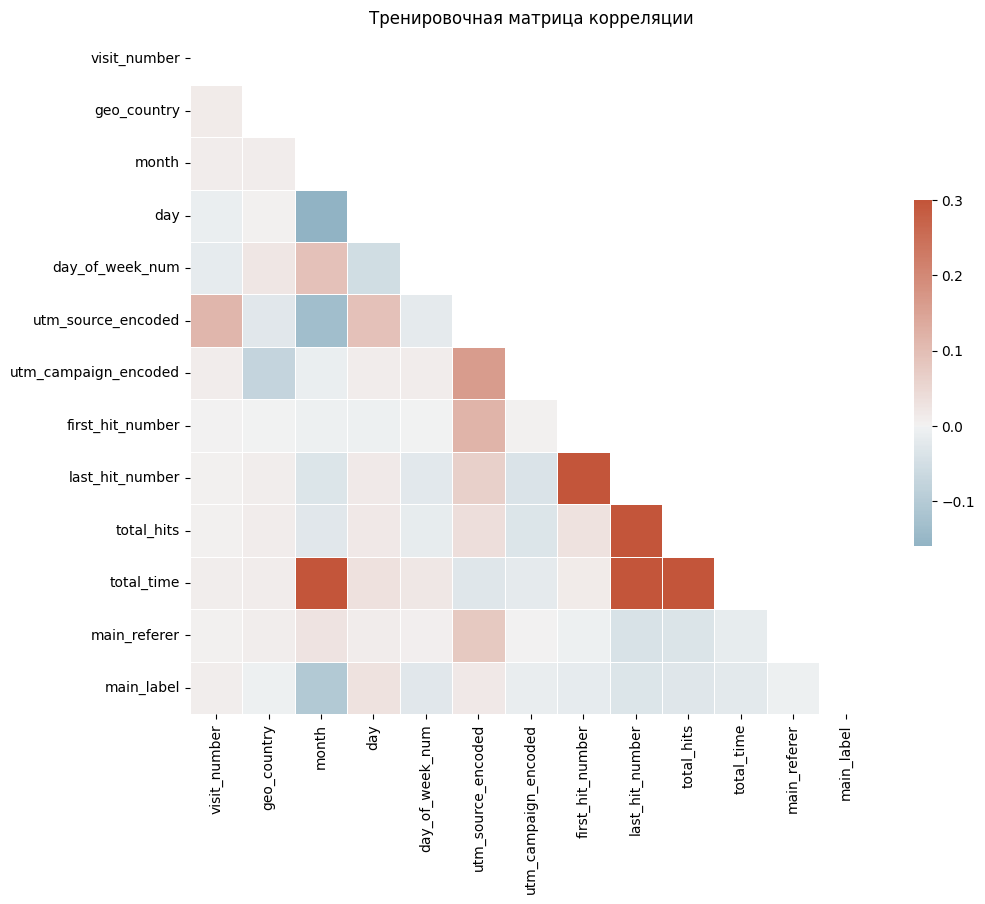

In [48]:
len(data)

non_date_columns_Train = data.select_dtypes(include=[np.number]).columns
correlation_matrix = data[non_date_columns_Train].corr(method='pearson')
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Тренировочная матрица корреляции')
plt.show()

In [49]:
inform(data)

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
Index: 1732266 entries, 0 to 1860041
Data columns (total 22 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   session_id             object  
 1   client_id              object  
 2   visit_number           int16   
 3   utm_medium             category
 4   device_category        category
 5   device_brand           category
 6   geo_country            uint8   
 7   month                  uint8   
 8   day                    uint8   
 9   day_of_week_num        uint8   
 10  utm_source_encoded     int16   
 11  utm_campaign_encoded   int16   
 12  geo_city_grouped       category
 13  first_hit_number       float64 
 14  last_hit_number        float64 
 15  total_hits             float64 
 16  entry_page             category
 17  total_time             float64 
 18  main_category_grouped  category
 19  main_action_grouped    category
 20  main_referer           float64 
 21  main_label   

,session_id,client_id,visit_number,utm_medium,device_category,device_brand,geo_country,month,day,day_of_week_num,...,geo_city_grouped,first_hit_number,last_hit_number,total_hits,entry_page,total_time,main_category_grouped,main_action_grouped,main_referer,main_label
0,9055434745589932991.1637753792.1637753792,2108382700.163776,1,banner,mobile,Huawei,1,11,24,2,...,OTHER,3.0,4.0,2.0,podpiska.sberauto.com/,2.0,sub_page_view,sub_landing,30.0,1.0
1,905544597018549464.1636867290.1636867290,210838531.163687,1,cpm,mobile,Samsung,1,11,14,6,...,Moscow,3.0,3.0,1.0,podpiska.sberauto.com/,1.0,sub_page_view,sub_landing,30.0,1.0
2,9055446045651783499.1640648526.1640648526,2108385331.164065,1,banner,mobile,Huawei,1,12,28,1,...,OTHER,3.0,20.0,16.0,sberauto.com/cars?utm_source_initial=sbol&utm_...,16.0,search_form,search_form_region,22.0,46.0
3,9055447046360770272.1622255328.1622255328,2108385564.162225,1,cpc,mobile,Xiaomi,1,5,29,5,...,Moscow,2.0,7.0,3.0,podpiska.sberauto.com/,0.0,sub_page_view,sub_landing,2.0,1.0
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2,cpc,mobile,Xiaomi,1,5,29,5,...,Moscow,2.0,3.0,2.0,sberauto.com/cars?city=1&rental_page=rental_on...,0.0,quiz,quiz_show,2.0,1.0




Описательная статистика:


,visit_number,geo_country,month,day,day_of_week_num,utm_source_encoded,utm_campaign_encoded,first_hit_number,last_hit_number,total_hits,total_time,main_referer,main_label
count,1.732266e+06,1.732266e+06,1.732266e+06,1.732266e+06,1.732266e+06,1.732266e+06,1.732266e+06,1.732266e+06,1.732266e+06,1.732266e+06,1.732266e+06,1.732266e+06,1.732266e+06
mean,2.627835e+00,9.712267e-01,9.280104e+00,1.709707e+01,2.793567e+00,6.697316e+00,1.259704e+01,3.284639e+00,1.445757e+01,9.054740e+00,3.766752e+00,2.824396e+02,1.050796e+02
std,1.164260e+01,1.671688e-01,2.208880e+00,8.791783e+00,1.987062e+00,9.826379e+00,2.833711e+01,5.376028e+00,1.959534e+01,1.387727e+01,9.947141e+00,2.480100e+03,1.331849e+03
min,1.000000e+00,0.000000e+00,5.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
25%,1.000000e+00,1.000000e+00,7.000000e+00,1.000000e+01,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00
50%,1.000000e+00,1.000000e+00,1.000000e+01,1.800000e+01,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,8.000000e+00,4.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00
75%,1.000000e+00,1.000000e+00,1.100000e+01,2.500000e+01,4.000000e+00,8.000000e+00,7.000000e+00,3.000000e+00,1.800000e+01,1.100000e+01,2.000000e+00,3.000000e+01,1.000000e+00
max,5.640000e+02,1.000000e+00,1.200000e+01,3.100000e+01,6.000000e+00,2.930000e+02,4.120000e+02,4.930000e+02,5.000000e+02,7.680000e+02,4.960000e+02,3.787400e+04,3.841000e+04




Количество пропусков
session_id: 0
client_id: 0
visit_number: 0
utm_medium: 0
device_category: 0
device_brand: 0
geo_country: 0
month: 0
day: 0
day_of_week_num: 0
utm_source_encoded: 0
utm_campaign_encoded: 0
geo_city_grouped: 0
first_hit_number: 0
last_hit_number: 0
total_hits: 0
entry_page: 0
total_time: 0
main_category_grouped: 0
main_action_grouped: 0
main_referer: 0
main_label: 0




'Количествово дубликатов:0'



Количество уникальных значений
session_id: 1732266
client_id: 1320702
visit_number: 533
utm_medium: 54
device_category: 3
device_brand: 200
geo_country: 2
month: 8
day: 31
day_of_week_num: 7
utm_source_encoded: 280
utm_campaign_encoded: 406
geo_city_grouped: 11
first_hit_number: 298
last_hit_number: 437
total_hits: 347
entry_page: 209101
total_time: 282
main_category_grouped: 11
main_action_grouped: 18
main_referer: 21864
main_label: 2414


In [42]:
data = data.dropna(subset=['first_hit_number'])

In [ ]:

data['first_hit_number'] = data['first_hit_number'].fillna(0)
data['first_hit_number'] = data['first_hit_number'].astype('int32')
data['last_hit_number'] = data['last_hit_number'].fillna(0)
data['last_hit_number'] = data['last_hit_number'].astype('int32')
data['total_hits'] = data['total_hits'].fillna(0)
data['total_hits'] = data['total_hits'].astype('int32')
data['total_time'] = data['total_time'].fillna(0)
data['total_time'] = data['total_time'].astype('int32')
data['main_referer'] = data['main_referer'].fillna(0)
data['main_referer'] = data['main_referer'].astype('int32')
data['main_label'] = data['main_label'].fillna(0)
data['main_label'] = data['main_label'].astype('int32')

data['entry_page'] = data['entry_page'].astype(str)
data['entry_page'] = data['entry_page'].fillna(0)
data['entry_page'] = data['entry_page'].astype('category')
data['main_category'] = data['main_category'].astype(str)
data['main_category'] = data['main_category'].fillna(0)
data['main_category'] = data['main_category'].astype('category')
data['main_action'] = data['main_action'].astype(str)
data['main_action'] = data['main_action'].fillna(0)
data['main_action'] = data['main_action'].astype('category')
data['main_category_grouped'] = data['main_category_grouped'].astype(str)
data['main_category_grouped'] = data['main_category_grouped'].fillna(0)
data['main_category_grouped'] = data['main_category_grouped'].astype('category')
data['main_action_grouped'] = data['main_action_grouped'].astype(str)
data['main_action_grouped'] = data['main_action_grouped'].fillna(0)
data['main_action_grouped'] = data['main_action_grouped'].astype('category')

In [43]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

In [55]:


# 1. Функция для уменьшения кардинальности категориальных признаков
def reduce_cardinality(df, categorical_features, max_categories=50):
    """Уменьшает количество категорий для высококардинальных признаков"""
    df = df.copy()
    for col in categorical_features:
        if col in df.columns and df[col].nunique() > max_categories:
            top_categories = df[col].value_counts().nlargest(max_categories-1).index
            df[col] = np.where(df[col].isin(top_categories), df[col], 'OTHER')
    return df

# 2. Определение типов признаков
numeric_features = [
    'visit_number',
    'day_of_week_num',
    'month',
    'day',
    'utm_source_encoded',
    'utm_campaign_encoded',
   # 'utm_adcontent_encoded',
   # 'utm_keyword_encoded',
   # 'device_model_encoded',
    'first_hit_number',
    'last_hit_number',
    'total_hits',
    'total_time',
    'main_referer',
    'main_label',
    'geo_country'
]


categorical_features = [
    'utm_medium',
    'device_category',
   # 'device_os',
    'device_brand',
   # 'device_screen_resolution',
    #'device_model',
    #'device_browser',
    'geo_city_grouped',
    'entry_page',
    'main_category_grouped'
   # 'main_action_grouped'
]

# 3. Пайплайн для числовых признаков
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('discretizer', KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile'))
])

# 4. Пайплайн для категориальных признаков
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# 5. Общий препроцессор
preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, numeric_features),
    ('categorical', categorical_pipeline, categorical_features)
], remainder='drop')

# 6. Финальный пайплайн с классификатором
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', HistGradientBoostingClassifier(
        random_state=42
    ))
])


In [56]:
# 1. Функция для фильтрации редких классов
def filter_rare_classes(y, min_samples=2):
    """Удаляет классы с количеством образцов меньше min_samples"""
    value_counts = y.value_counts()
    rare_classes = value_counts[value_counts < min_samples].index
    return y[~y.isin(rare_classes)]

# 2. Модифицированная функция обучения
def train_model(data, target_column, min_class_samples=5):
    """Обучает модель с фильтрацией редких классов"""
    # Уменьшаем кардинальность категориальных признаков
    data = reduce_cardinality(data, categorical_features)
    
    # Преобразуем категориальные колонки в правильный тип
    for col in categorical_features:
        if col in data.columns:
            data[col] = data[col].astype('category')
    
    # Разделяем на признаки и целевую переменную
    X = data.drop(columns=[target_column, 'session_id'], errors='ignore')
    y = data[target_column]
    
    # Фильтруем редкие классы
    mask = y.isin(filter_rare_classes(y, min_samples=min_class_samples))
    X_filtered = X[mask]
    y_filtered = y[mask]
    
    # Разделяем на train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered
    )
    
    # Определяем индексы категориальных признаков
    preprocessor.fit(X_train)
    categorical_indices = list(range(
        len(numeric_features), 
        len(numeric_features) + len(categorical_features)
    ))
    
    # Настраиваем и обучаем модель
    model_pipeline.set_params(
        classifier__categorical_features=categorical_indices,
        classifier__class_weight='balanced'  # Для несбалансированных данных
    )
    
    model_pipeline.fit(X_train, y_train)
    
    # Оценка качества
    train_score = model_pipeline.score(X_train, y_train)
    test_score = model_pipeline.score(X_test, y_test)
    print(f"Train accuracy: {train_score:.3f}, Test accuracy: {test_score:.3f}")
    print(f"Использовано {len(np.unique(y_filtered))} классов из {len(np.unique(y))}")
    
    return model_pipeline

# Пример использования
if __name__ == "__main__":
    
    # Обучение модели с фильтрацией редких классов (минимум 5 образцов на класс)
    trained_pipeline = train_model(data, 'main_action_grouped', min_class_samples=5)
    
    # Предсказания (только для известных классов)
    predictions = trained_pipeline.predict(data)
    print("Первые 10 предсказаний:", predictions[:10])

Train accuracy: 0.717, Test accuracy: 0.716
Использовано 18 классов из 18
Первые 10 предсказаний: ['sub_landing' 'sub_landing' 'search_form_model_select' 'sub_landing'
 'quiz_show' 'search_form_mark_select' 'view_new_card'
 'search_form_model_select' 'view_new_card' 'search_form_model_select']


In [58]:
print("Распределение классов:")
print(data['main_action_grouped'].value_counts())

Распределение классов:
main_action_grouped
sub_landing                           714427
view_card                             376372
view_new_card                         181149
OTHER                                 169769
sub_view_cars_click                    78057
search_form_region                     49978
quiz_show                              34149
pagination_click                       28432
sap_search_form_cost_to                18416
showed_number_ads                      16470
search_form_search_btn                 15880
go_to_car_card                         15539
search_form_model_select               11117
sap_search_form_cost_from               7665
search_form_mark_select                 7158
search_form_search_car_type_select      6376
photos                                   931
photos_all                               381
Name: count, dtype: int64


In [ ]:
#%pip install --upgrade dask scikit-learn catboost

In [60]:
# 1. Функция для уменьшения кардинальности категориальных признаков (без изменений)
def reduce_cardinality(df, categorical_features, max_categories=50):
    """Уменьшает количество категорий для высококардинальных признаков"""
    df = df.copy()
    for col in categorical_features:
        if col in df.columns and df[col].nunique() > max_categories:
            top_categories = df[col].value_counts().nlargest(max_categories-1).index
            df[col] = np.where(df[col].isin(top_categories), df[col], 'OTHER')
    return df

# 2. Функция для фильтрации редких классов (без изменений)
def filter_rare_classes(y, min_samples=2):
    """Удаляет классы с количеством образцов меньше min_samples"""
    value_counts = y.value_counts()
    rare_classes = value_counts[value_counts < min_samples].index
    return y[~y.isin(rare_classes)]


# 4. Модифицированная функция обучения с LGBM и сохранением модели
def train_and_save_lgbm_model(data, target_column, output_file='model.pkl', min_class_samples=5):
    """Обучает LGBM модель с оптимизацией памяти и сохраняет в файл"""
    # Уменьшаем кардинальность категориальных признаков
    data = reduce_cardinality(data, categorical_features)
    
    # Преобразуем категориальные колонки в правильный тип
    for col in categorical_features:
        if col in data.columns:
            data[col] = data[col].astype('category')
    
    # Разделяем на признаки и целевую переменную
    X = data.drop(columns=[target_column, 'session_id'], errors='ignore')
    y = data[target_column]
    
    # Фильтруем редкие классы
    mask = y.isin(filter_rare_classes(y, min_samples=min_class_samples))
    X_filtered = X[mask].copy()
    y_filtered = y[mask].copy()
    
    # Освобождаем память
    del X, y, mask
    gc.collect()
    
    # Разделяем на train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered
    )
    
    # Создаем пайплайны с оптимизацией памяти
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
        ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ])
    
    preprocessor = ColumnTransformer([
        ('numeric', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ], remainder='drop')
    
    # Инициализация LGBM с параметрами для экономии памяти
    lgbm_params = {
        'random_state': 42,
        'n_estimators': 150,
        'learning_rate': 0.2,
        'max_depth': 9,
        'num_leaves': 31,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'n_jobs': -1,
        'verbose': -1,
    }
    
    

    # Определяем пространство параметров для поиска
    param_grid = {
        # Основные параметры
        'objective': ['binary', 'multiclass'],  # Автоматически определится по данным
        'boosting_type': ['gbdt', 'dart'],  # 'goss' и 'rf' тоже можно попробовать
        
        # Параметры сложности модели
        'n_estimators': [100],  # Количество деревьев
        'learning_rate': [0.05, 0.1, 0.2],  # Скорость обучения
        'max_depth': [5, 7, 9],  # -1 означает без ограничения
        'num_leaves': [31, 63, 127],  # Должно быть <= 2^max_depth
        
        # Параметры регуляризации
        'reg_alpha': [0, 0.1, 0.5],  # L1 регуляризация
        'reg_lambda': [0, 0.1, 0.5],  # L2 регуляризация
        'min_child_samples': [10, 20],  # Минимальное количество данных в листе
        
        # Параметры подвыборки
        'subsample': [0.6, 0.8, 1.0],  # Доля случайных строк
        'colsample_bytree': [0.6, 0.8, 1.0],  # Доля признаков
        'subsample_freq': [0, 5, 7],  # Частота подвыборки строк
        
        # Категориальные признаки
        'categorical_feature': [None],  # Автоматически определится
        'max_cat_to_onehot': [4, 10],  # Порог для one-hot кодирования
        
        # Другие параметры
        #'class_weight': [None, 'balanced'],  # Для несбалансированных данных
        'importance_type': ['split', 'gain']  # Тип важности признаков
    }

    # Создаем базовую модель
    lgbm = LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)

    # Создаем GridSearchCV объект
    #grid_search = GridSearchCV(
    #    estimator=lgbm,
    #    param_grid=param_grid,
    #    scoring='roc_auc',  # Или другая метрика
    #    cv=2,  # Количество фолдов
    #    n_jobs=-1,  # Использовать все ядра
    #    verbose=1
    #)

    # Встраиваем в пайплайн
    #model_pipeline = Pipeline([
    #    ('preprocessor', preprocessor),
    #    ('grid_search', grid_search)
    #])

    # Обучение с поиском параметров
    #model_pipeline.fit(X_train, y_train)

    # Лучшие параметры
    #print("Лучшие параметры:", grid_search.best_params_)
    #print("Лучший ROC-AUC:", grid_search.best_score_)

    # Сохранение лучшей модели
    #best_model = grid_search.best_estimator_
    
    # Для многоклассовой классификации
    if len(y_train.unique()) > 2:
        lgbm_params['objective'] = 'multiclass'
        lgbm_params['metric'] = 'multi_logloss'
    else:
        lgbm_params['objective'] = 'binary'
        lgbm_params['metric'] = 'auc'
    
    model_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LGBMClassifier(**lgbm_params))
    ])
    
    # Обучаем модель
    model_pipeline.fit(X_train, y_train)
    
    # Оценка качества
    if len(y_train.unique()) > 2:
        y_train_pred = model_pipeline.predict_proba(X_train)
        y_test_pred = model_pipeline.predict_proba(X_test)
        train_score = roc_auc_score(y_train, y_train_pred, multi_class='ovr')
        test_score = roc_auc_score(y_test, y_test_pred, multi_class='ovr')
    else:
        y_train_pred = model_pipeline.predict_proba(X_train)[:, 1]
        y_test_pred = model_pipeline.predict_proba(X_test)[:, 1]
        train_score = roc_auc_score(y_train, y_train_pred)
        test_score = roc_auc_score(y_test, y_test_pred)
    
    print(f"Train ROC-AUC: {train_score:.4f}, Test ROC-AUC: {test_score:.4f}")
    print(f"Использовано {len(y_filtered.unique())} классов из {len(data[target_column].unique())}")
    
    # Сохранение модели в файл
    with open(output_file, 'wb') as f:
        pickle.dump(model_pipeline, f)
    
    print(f"Модель успешно сохранена в файл: {output_file}")
    
    return model_pipeline

# Пример использования
if __name__ == "__main__":
    
    # Обучение модели LGBM и сохранение
    model = train_and_save_lgbm_model(
        data, 
        target_column='main_action_grouped', 
        output_file='lgbm_model.pkl',
        min_class_samples=5
    )
    
    # Пример загрузки модели из файла
    # with open('lgbm_model.pkl', 'rb') as f:
    #     loaded_model = pickle.load(f)
    
    # Предсказания (только для известных классов)
    predictions = model.predict(data)
    print("Первые 10 предсказаний:", predictions)

Train ROC-AUC: 0.9524, Test ROC-AUC: 0.9277
Использовано 18 классов из 18
Модель успешно сохранена в файл: lgbm_model.pkl
Первые 10 предсказаний: ['sub_landing' 'sub_landing' 'search_form_region' ... 'view_card'
 'sub_landing' 'view_new_card']
